In [65]:
import pandas as pd
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Merge datasets

In [66]:
coffee_price = pd.read_csv("data/daily_coffee_price.csv").drop(columns=["Unnamed: 0"])
curr = pd.read_csv("data/daily_currency_USD_base.csv").drop(columns=["Unnamed: 0"])
weather = pd.read_csv("data/weather_data.csv")

In [67]:
# Currency has different date format
curr["date"] = curr["date"].apply(lambda x: "-".join(x.split("-")[::-1]))

# Rename currencies
curr_names = [i[3:] for i in curr.columns[1:]]
curr_names.insert(0, "date")

In [68]:
curr.columns = curr_names

# Use only currencies of countries that have direct relation ship to coffee
coffee_curr = ['date', 'AOA', 'BIF', 'BRL', 'CDF', 'COP', 'CRC',
       'CUP', 'DOP', 'ETB', 'GHS', 'GTQ', 'HNL', 'IDR', 'INR', 'JMD', 'KES',
       'LRD', 'MGA', 'MWK', 'MXN', 'NIO', 'NPR', 'PAB', 'PEN', 'PGK', 'PHP',
       'PYG', 'RWF', 'SLL', 'SVC', 'THB', 'TZS', 'UGX', 'XAF', 'XOF', 'YER',
       'ZMW', 'ZWL']

# Leave only important features
curr = curr[coffee_curr]

In [69]:
coffee_curr = pd.merge(coffee_price, curr, how='left', on='date')
df = pd.merge(coffee_curr, weather, how='left', on='date')
df.head()

,date,composite_ind,columbian_milds,other_milds,brazilian_nat,robustas,AOA,BIF,BRL,CDF,...,peru_averagePressure,peru_averageCloudCover,nicaragua_totalSnow_cm,nicaragua_maxtempC,nicaragua_mintempC,nicaragua_sunHour,nicaragua_averageHumidity,nicaragua_averageWindspeedKmph,nicaragua_averagePressure,nicaragua_averageCloudCover
0,2017-08-01,130.82,158.74,153.49,136.18,104.83,165.093994,1722.560059,3.125799,1642.749511,...,1012.625,35.250,0.0,35.0,22.0,9.4,82.500,4.00,1003.25,59.875
1,2017-08-01,130.82,158.74,153.49,136.18,104.83,165.093994,1722.560059,3.125799,1642.749511,...,1012.625,35.250,0.0,35.0,22.0,9.4,82.500,4.00,1003.25,59.875
2,2017-08-01,130.82,158.74,153.49,136.18,104.83,165.093994,1722.560059,3.125799,1642.749511,...,1012.625,35.250,0.0,35.0,22.0,9.4,82.500,4.00,1003.25,59.875
3,2017-08-02,133.23,162.06,156.95,139.18,105.86,165.093994,1723.010010,3.113600,1560.949951,...,1012.500,13.625,0.0,31.0,21.0,9.4,96.625,3.75,1003.25,77.125
4,2017-08-02,133.23,162.06,156.95,139.18,105.86,165.093994,1723.010010,3.113600,1560.949951,...,1012.500,13.625,0.0,31.0,21.0,9.4,96.625,3.75,1003.25,77.125


## Handle missing values

We are missing 42 rows on weather so, we will drop it

In [70]:
df.isna().sum()

date                               0
composite_ind                      0
columbian_milds                    0
other_milds                        0
brazilian_nat                      0
robustas                           0
AOA                                0
BIF                                0
BRL                                0
CDF                                0
COP                                0
CRC                                0
CUP                                0
DOP                                0
ETB                                0
GHS                                0
GTQ                                0
HNL                                0
IDR                                0
INR                                0
JMD                                0
KES                                0
LRD                                0
MGA                                0
MWK                                0
MXN                                0
NIO                                0
N

In [71]:
df = df.dropna()
df.shape

(429, 140)

## Feature research

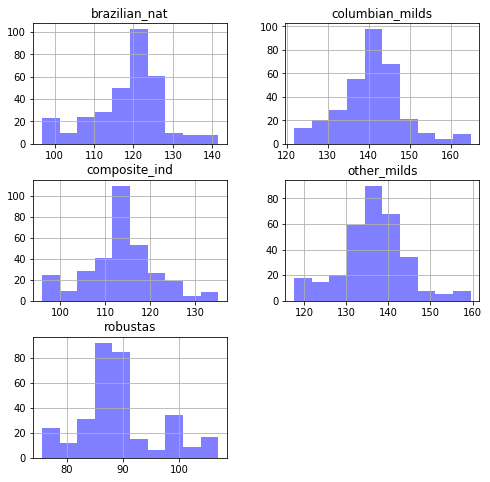

In [72]:
%matplotlib inline
hist_plot = coffee_price.hist(color='blue', alpha=0.5, figsize=(8, 8))

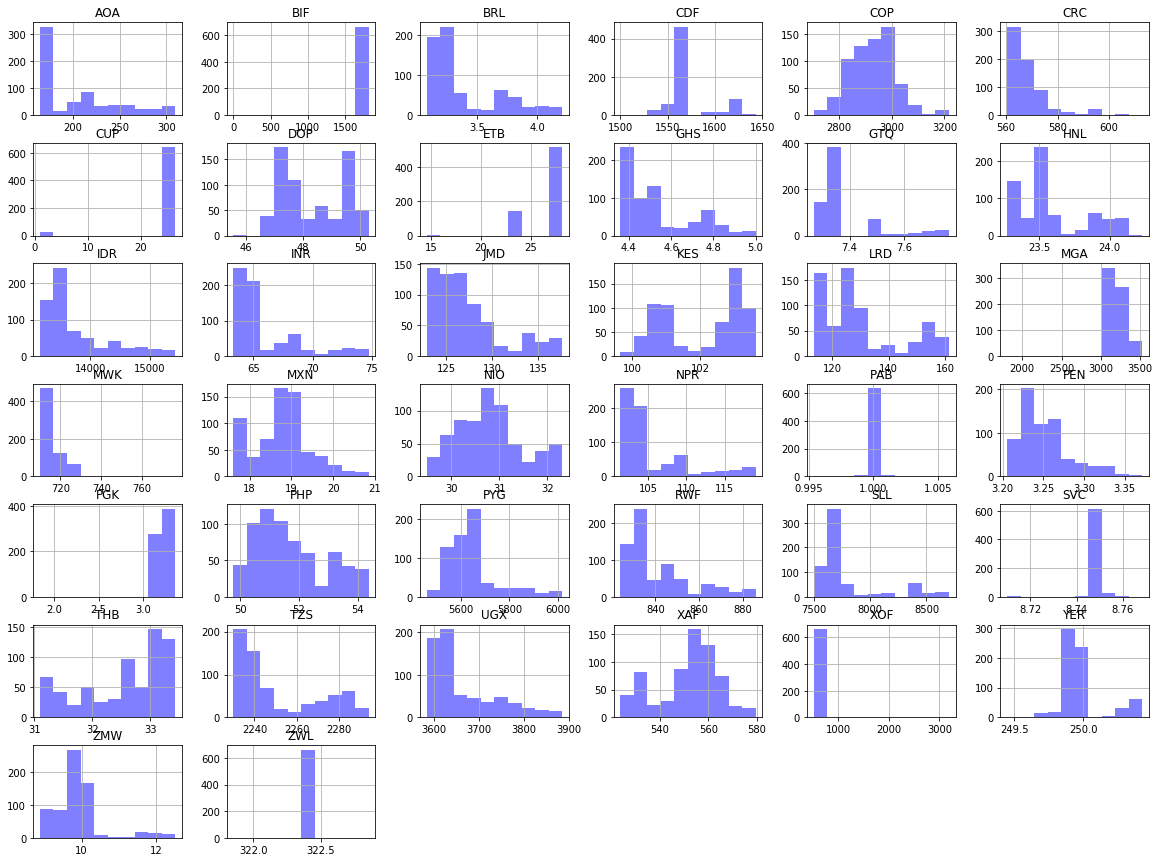

In [73]:
hist_plot = curr.hist(color='blue', alpha=0.5, figsize=(20, 15))

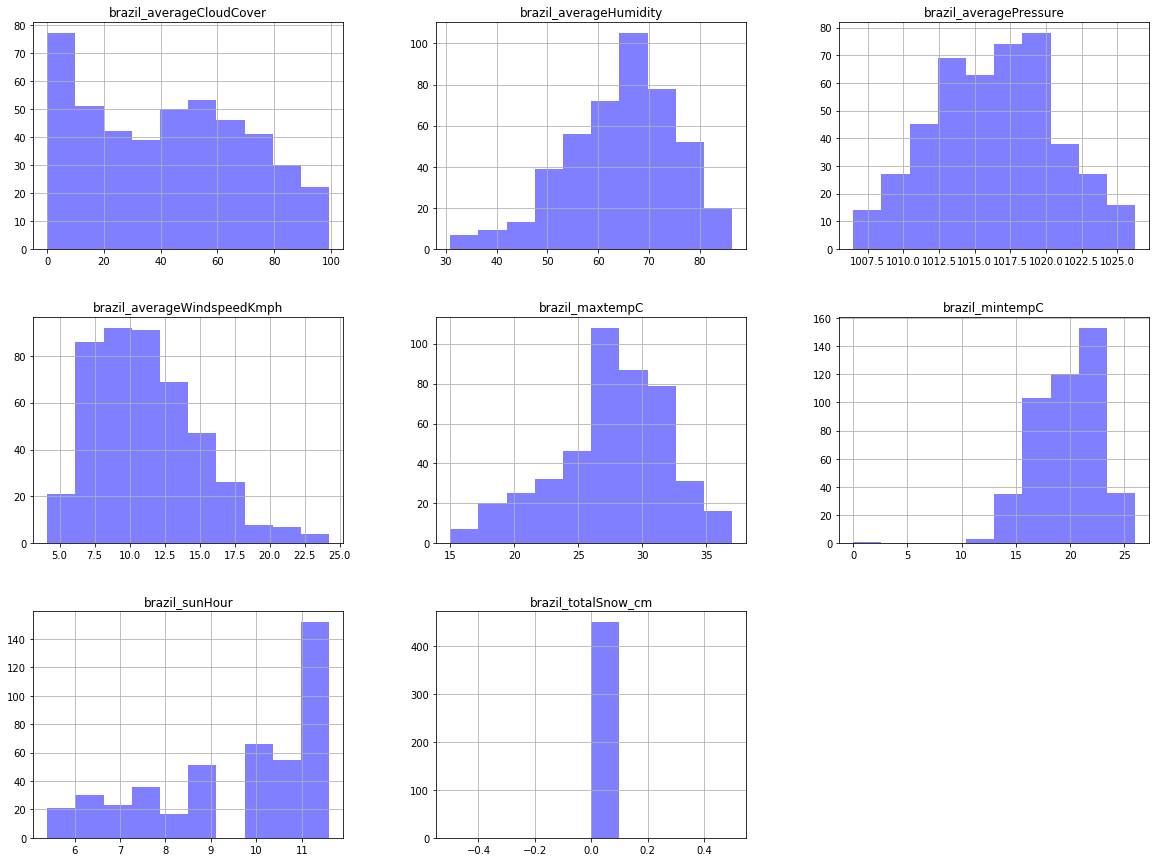

In [74]:
hist_plot = weather.iloc[:, :9].hist(color='blue', alpha=0.5, figsize=(20, 15))

### We can drop total snow, because it is, as expected 0, respectively has very low variance

In [75]:
countries = ["brazil", "vietnam", "colombia", "indonesia", "ethiopia", "honduras", "india", "uganda", "mexico", "guatemala", "peru", "nicaragua"]
snow_feat = [i + "_totalSnow_cm" for i in countries]
df = df.drop(columns=snow_feat)

In [76]:
df.shape

(429, 128)

## Standardize features

In [77]:
from sklearn import preprocessing
df_z = pd.DataFrame(preprocessing.scale(df.iloc[:, 3:]), columns=df.columns[3:])

## Feature selection

### Split into X and y

In [78]:
from sklearn.model_selection import train_test_split

X = df_z
y = df.columbian_milds

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Apply PCA to see redundant features

In [79]:
from sklearn.decomposition import PCA

n = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 110, 120]
pcas = []

for i in n:
    pcas.append(PCA(n_components=i))

In [80]:
trains = []
valids = []
var_explained = []

for i in pcas:
    trains.append(i.fit_transform(X_train))
    var_explained.append(i.explained_variance_ratio_.sum())
    valids.append(i.fit_transform(X_test))

### Visualize how do the models with given ns differ with regard to the amount of variance they explain.

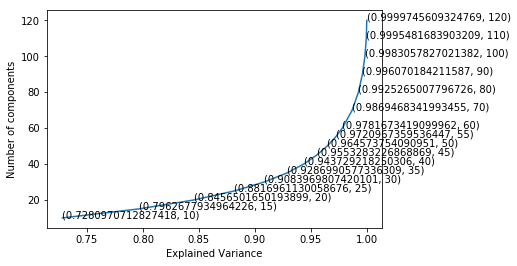

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(var_explained, n)

for xy in zip(var_explained, n):
    ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel("Explained Variance")
plt.ylabel("Number of components")
plt.show()

### Select best 40 features

In [82]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2

kbest = SelectKBest(f_regression, k=40)
X_new = kbest.fit(X, y).transform(X)

cols = kbest.get_support(indices=True)
X.columns[cols]

Index(['other_milds', 'brazilian_nat', 'robustas', 'AOA', 'BRL', 'CDF', 'DOP',
       'ETB', 'GHS', 'GTQ', 'HNL', 'IDR', 'INR', 'JMD', 'KES', 'LRD', 'MGA',
       'MWK', 'MXN', 'NIO', 'NPR', 'PEN', 'PHP', 'PYG', 'RWF', 'SLL', 'TZS',
       'UGX', 'YER', 'ZMW', 'vietnam_mintempC', 'colombia_sunHour',
       'indonesia_averageWindspeedKmph', 'ethiopia_maxtempC',
       'ethiopia_averageWindspeedKmph', 'ethiopia_averageCloudCover',
       'uganda_averageHumidity', 'mexico_maxtempC', 'guatemala_maxtempC',
       'guatemala_averageWindspeedKmph'],
      dtype='object')

### Create new dataset with best features

In [83]:
X = X.iloc[:, cols].reset_index(drop=True)

### Select the best model

In [84]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('BR', BayesianRidge()))
models.append(('SVM', SVR()))
models.append(('RF', RandomForestRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))
models.append(('Bagging', BaggingRegressor()))

# evaluate each model in turn
results = []
names = []
scoring = 'r2'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=42)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.867887 (0.096926)
KNN: -0.617477 (0.958444)
BR: 0.867115 (0.094766)
SVM: -0.186105 (0.738007)
RF: 0.832912 (0.116082)
AdaBoost: 0.831111 (0.120867)
Bagging: 0.802737 (0.141068)


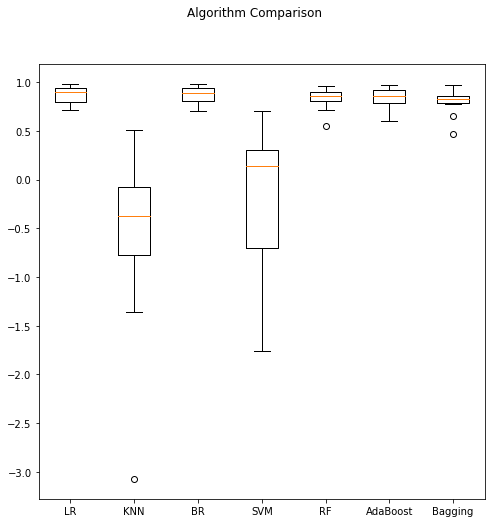

In [85]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### We will use Linear Regression

In [86]:
# Split into train and test
y = pd.DataFrame(df.columbian_milds)

In [87]:
model = LinearRegression()
scores = []

kfold = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train, :])
    score = model.score(X.iloc[test,:], y.iloc[test, :])
    scores.append(score)

print(sum(scores) / 3)

0.9893191250339167


### Use only weather & currency features

In [88]:
# Standardize
df_z = pd.DataFrame(preprocessing.scale(df.iloc[:, 6:]), columns=df.columns[6:])

# Get X and target
X = df_z
y = pd.DataFrame(df.columbian_milds)

# Select best features
kbest = SelectKBest(f_regression, k=40)
X_new = kbest.fit(X, y).transform(X)

# Leave only best features
cols = kbest.get_support(indices=True)
X = X.iloc[:, cols].reset_index(drop=True)

In [89]:
model = AdaBoostRegressor(learning_rate=0.05, n_estimators=200, loss='square')
scores = []

kfold = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train, :])
    score = model.score(X.iloc[test,:], y.iloc[test, :])
    scores.append(score)

print(sum(scores) / 3)

0.9105358113883316
